# Basline blur classifier model

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import random
import copy
import io
import cv2
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


In [2]:
# ResNet input size
input_size = (224,224)

# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.4857, 0.4296, 0.3671], [0.2854, 0.2750, 0.2751])
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.4550, 0.4196, 0.3736], [0.2908, 0.2805, 0.2861]) 
    ]),
}


## Dataset

In [3]:
class BlurDataset(Dataset):

    def __init__(self, root_dir, imgs_list, transform=None):

        self.root_dir = root_dir
        self.imgs_list = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

         # VizWiz dataset case
        img_name = os.path.join(self.root_dir, self.imgs_list[idx][0])
        img_label = self.imgs_list[idx][1]

        image = Image.open(img_name)

        if self.transform:
            sample = self.transform(image)

        return sample, float(img_label)

Load dataset

In [4]:
with open('../data/vw_blur_dataset.json', encoding='UTF-8') as m_json_file:
    data = json.load(m_json_file)
    m_train_data = data["train"]
    m_val_data = data["val"]

## Training

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_path):
    """
    Train the model
    """
    
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels.unsqueeze(1).float())
                    losses[phase].append(loss.cpu().detach().numpy())
                    #_, preds = torch.max(outputs, 1)
                    preds = torch.round(torch.sigmoid(outputs))
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.unsqueeze(1))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    
    torch.save(model.state_dict(), save_path)
    
    return model, acc_history, losses

In [6]:
def initialize_model(num_classes, model_name):
    """
    Initialize blur model for binary classifaction
    """
    
    if str(model_name) == "vgg16" or str(model_name) == "convnext":
        
        if str(model_name) == "vgg16":
            model = models.vgg16(weights='IMAGENET1K_V1')
        else:
            model = models.convnext_tiny(weights='IMAGENET1K_V1')
            model.add_module("dropout", nn.Dropout(0.04653))
                                         
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
                                         
    elif str(model_name) == "resnet":
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(512, num_classes)
        
    input_size = 224
        
    return model, input_size


# Number of classes in the dataset
num_classes = 1

# Initialize the model
model_name = "convnext"
model, input_size = initialize_model(num_classes, model_name)
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [7]:
# Send the model to GPU
model = model.to(device)

# Binary cross entropy + sigmoid
criterion = nn.BCEWithLogitsLoss()

**Model params**

In [8]:
hp = {
    "vgg16" : {"lr" : 8.76718e-05,
                "wd" : 1.62129e-09 
                },
      "resnet" : {"lr" : 1.92388e-05,
                  "wd" : 2.89728e-07
                 },
      "convnext" : {"lr" : 1.24856e-05,
                  "wd" : 5.85242e-08
                   }        
     }

In [9]:
batch_size = 128
num_epochs = 5
lr = hp[model_name]["lr"]
wd = hp[model_name]["wd"]
optimizer_ft = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

**Data**

In [10]:
train_dataset = BlurDataset('/media/arnau/PEN/TFG/train/', m_train_data, data_transforms["train"])
val_dataset = BlurDataset('/media/arnau/PEN/TFG/val/', m_val_data, data_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

dataloaders_dict = {"train": train_loader, "val": val_loader}

**Model trainning**

Epoch 0/4
----------
train Loss: 0.5513 Acc: 0.7432
val Loss: 0.3870 Acc: 0.8366

Epoch 1/4
----------
train Loss: 0.2926 Acc: 0.8893
val Loss: 0.2789 Acc: 0.8826

Epoch 2/4
----------
train Loss: 0.2366 Acc: 0.9079
val Loss: 0.2597 Acc: 0.8920

Epoch 3/4
----------
train Loss: 0.2068 Acc: 0.9190
val Loss: 0.2550 Acc: 0.8986

Epoch 4/4
----------
train Loss: 0.1811 Acc: 0.9301
val Loss: 0.2452 Acc: 0.9089

Training complete in 16m 59s
Best val Acc: 0.908920


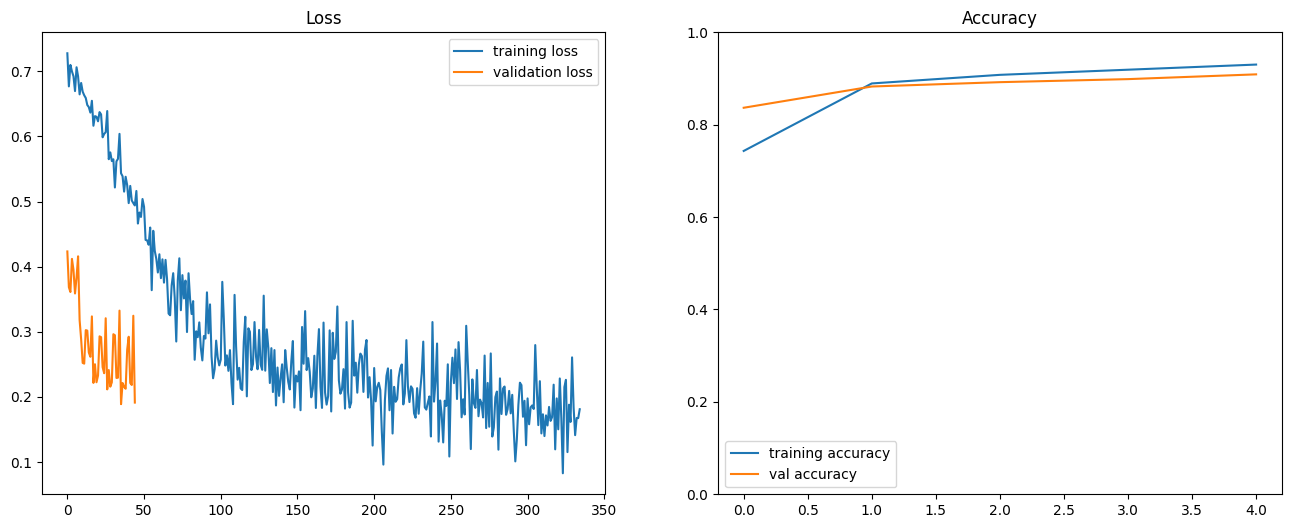

In [11]:
save_path = f'../outputs/best_{model_name}.pth'

if not os.path.exists(save_path):
    # Train and evaluate
    model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, 
                                      num_epochs=num_epochs, save_path=save_path)
    
    # plot the losses and accuracies
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(losses["train"], label="training loss")
    ax1.plot(losses["val"], label="validation loss")
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot([x.cpu().numpy() for x in hist["train"]],label="training accuracy")
    ax2.plot([x.cpu().numpy() for x in hist["val"]],label="val accuracy")
    ax2.set_ylim([0, 1])
    ax2.legend()

    plt.show()

## Results

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 27820897


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate(model, loss_fn, test_loader, device):
    """
    Evaluate the model on the test set
    """
    
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.float(), targets.float().unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        predicted = torch.round(torch.sigmoid(outputs))
        #_, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets.unsqueeze(1)).sum().item()
        y_true += targets.cpu().numpy().tolist()
        y_pred += predicted.cpu().detach().numpy().tolist()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total
    test_f1 = f1_score(y_true, y_pred)
    test_precision = precision_score(y_true, y_pred)
    test_recall = recall_score(y_true, y_pred)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test F1 Score: {test_f1 * 100:.2f}%")
    print(f"Test Precision: {test_precision * 100:.2f}%")
    print(f"Test Recall: {test_recall * 100:.2f}%")
    
    # Calculate AUC-ROC score and ROC curve using sklearn
    auc_roc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_roc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


**Results on test set**

Test Loss: 0.2547
Test Accuracy: 91.10%
Test F1 Score: 91.24%
Test Precision: 90.99%
Test Recall: 91.50%


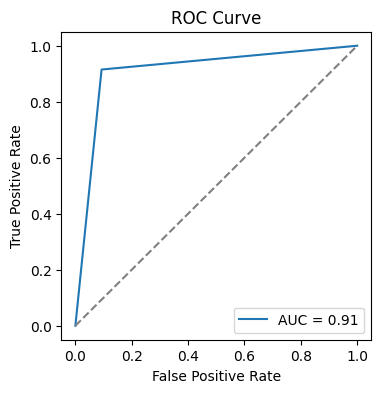

In [14]:
test_dataset = BlurDataset('/media/arnau/PEN/TFG/val/', data["test"], data_transforms["val"])
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

model.load_state_dict(torch.load(save_path))

evaluate(model, criterion, test_loader, device)

In [15]:
def inference(i):
    """
    Model outputs 1 if the image is blurred otherwise 0
    """
    
    img = Image.open(i)

    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),        
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(img_tensor)

    #_, predicted = torch.max(output.data, 1)
    predicted = torch.round(torch.sigmoid(output))
    pred = predicted.cpu().detach().numpy()[0]
    
    return pred

**Inference visualization**

Visualization of how the model performs

Model: Clear
True: Blur


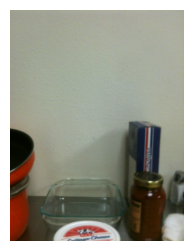

Model: Clear
True: Blur


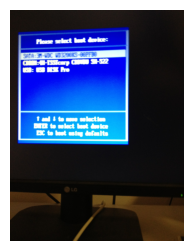

Model: Clear
True: Clear


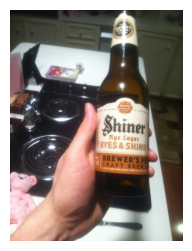

Model: Clear
True: Clear


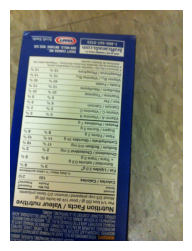

Model: Clear
True: Clear


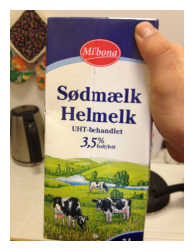

In [16]:
ten_random_imgs = random.choices(data["test"], k=5)


for i, (img, label) in enumerate(ten_random_imgs):
    plt.figure(figsize=(3, 3))
    img = '/media/arnau/PEN/TFG/val/' + img
    model_pred = inference(img)
    model_pred = "Blur" if model_pred == 1 else "Clear"
    print(f"Model: {model_pred}")
    true_label = "Blur" if label == 1 else "Clear"
    print(f"True: {true_label}")
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    img = (img.astype(np.float32) / np.max(img) * 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    plt.show()